In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import os, subprocess
import cooler
import cooltools.lib.plotting
from packaging import version
if version.parse(cooltools.__version__) < version.parse('0.5.4'):
    raise AssertionError("tutorials rely on cooltools version 0.5.4 or higher,"+
                        "please check your cooltools version and update to the latest")
import cooltools
import bioframe
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import warnings
from cytoolz import merge
from cooltools.api.saddle import saddle_strength
import cooltools
import pysam

In [3]:
def load_eig_track(path_to_cool: str, path_to_genome: str = '/home/estsoi/mm10.fasta'):
    clr = cooler.Cooler(path_to_cool)
    rename_dict = {'1': 'chr1', '2': 'chr2', '3': 'chr3', '4': 'chr4', '5': 'chr5', 
                    '6': 'chr6', '7': 'chr7', '8': 'chr8', '9': 'chr9',
                    '10': 'chr10', '11': 'chr11', '12': 'chr12', '13': 'chr13', '14': 'chr14', 
                    '15': 'chr15', '16': 'chr16', '17': 'chr17', '18': 'chr18', '19': 'chr19'}
    cooler.rename_chroms(clr, rename_dict)
    bins = clr.bins()[:]
    mm10_genome = bioframe.load_fasta(path_to_genome)
    ## note the next command may require installing pysam
    gc_cov = bioframe.frac_gc(bins[['chrom', 'start', 'end']], mm10_genome)
    view_df = pd.DataFrame({'chrom': clr.chromnames,
                            'start': 0,
                            'end': clr.chromsizes.values,
                            'name': clr.chromnames})
    cis_eigs = cooltools.eigs_cis(
                            clr,
                            gc_cov,
                            view_df=view_df,
                            n_eigs=3,
                            )
    eigenvector_track_control = cis_eigs[1][['chrom','start','end','E1']]
    return eigenvector_track_control

In [4]:
control = load_eig_track('/storage3/estsoi/Control/aligned/control_for_eigs_19.cool')
ncaph1 = load_eig_track('/storage3/estsoi/ncaph1_merged_comp/ncaph1_merged_comp_100k.cool')
ncaph2 = load_eig_track('/storage3/estsoi/ncaph2_merged_comp/ncaph2_merged_comp_100k.cool')

/home/estsoi/miniforge3/lib/python3.10/site-packages/bioframe/extras.py:316: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df.groupby("chrom", sort=False)[["start", "end"]].apply(_each)
/home/estsoi/miniforge3/lib/python3.10/site-packages/cooltools/lib/checks.py:550: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for name, group in track.groupby(track.columns[0]):
/home/estsoi/miniforge3/lib/python3.10/site-packages/bioframe/extras.py:316: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or

In [43]:
control

chrom     start       end        E1
0       chr1         0    100000       NaN
1       chr1    100000    200000       NaN
2       chr1    200000    300000       NaN
3       chr1    300000    400000       NaN
4       chr1    400000    500000       NaN
...      ...       ...       ...       ...
24634  chr19  61000000  61100000 -0.114029
24635  chr19  61100000  61200000  0.266596
24636  chr19  61200000  61300000  0.421464
24637  chr19  61300000  61400000       NaN
24638  chr19  61400000  61431716       NaN

[24639 rows x 4 columns]

In [50]:
((ncaph1['E1'] > 0) & (control['E1'] >0)).sum()

10542

In [51]:
((ncaph1['E1'] < 0) & (control['E1'] < 0)).sum()

11152

In [59]:
(ncaph1['E1'].isna() & control['E1'].isna()).sum()

1328

In [60]:
((ncaph1['E1'] < 0) & (control['E1'] >0)).sum()

944

In [61]:
((ncaph1['E1'] > 0) & (control['E1'] < 0)).sum()

617

In [ ]:
def compare_two_eigs(eig1:pd.DataFrame, eig2:pd.DataFrame):
    print(f"total1: {len(eig1)}, total2: {len(eig2)}")
    print(f"both are > 0 (A): {((eig1['E1'] > 0) & (eig2['E1'] > 0)).sum()}")
    print(f"both are < 0 (B): {((eig1['E1'] < 0) & (eig2['E1'] < 0)).sum()}")
    print(f"first is >0, second <0: {((eig1['E1'] > 0) & (eig2['E1'] < 0)).sum()}")
    print(f"first is <0, second >0: {((eig1['E1'] < 0) & (eig2['E1'] > 0)).sum()}")
    print(f"both do not have value: {(ncaph1['E1'].isna() & control['E1'].isna()).sum()}")

In [ ]:
compare_two_eigs(control, ncaph1)

total1: 24639, total2: 24639
both are > 0 (A): 10542
both are < 0 (B): 11152
first is >0, second <0: 944
first is <0, second >0: 617
both do not have value: 1328


In [ ]:
compare_two_eigs(control, ncaph2)

total1: 24639, total2: 24639
both are > 0 (A): 10599
both are < 0 (B): 11097
first is >0, second <0: 910
first is <0, second >0: 701
both do not have value: 1328


In [ ]:
compare_two_eigs(ncaph1, ncaph2)

total1: 24639, total2: 24639
both are > 0 (A): 10258
both are < 0 (B): 11076
first is >0, second <0: 901
first is <0, second >0: 1020
both do not have value: 1328


In [5]:
#LOAD GENOME ANNOTATIONS FROM NCBI AND UNIPROT FOR NAME CONVERSION
uniprot = pd.read_csv('/storage3/estsoi/expr_comp/mm10.knownGene.gtf', sep='\t', header=None, names=['chr', '2', 'type', 'start', 'end', '6', '7', '8', 'data'])
ncbi = pd.read_csv('/storage3/estsoi/expr_comp/mm10.ncbiRefSeq.gtf', sep='\t', header=None, names=['chr', '2', 'type', 'start', 'end', '6', '7', '8', 'data'])
#FUNCTIONS FOR NAME CONVERSION
def get_geneid(row):
    return row.data.split('\"')[1]

def get_ncbi_name(gene:str, df:pd.DataFrame = uniprot, df_ncbi: pd.DataFrame = ncbi):
    start = min(df[df['gene'] ==  gene]['start'])
    end = max(df[df['gene'] ==  gene]['end'])

    chr = df[df['gene'] ==  gene]['chr'].values[0]
    print(gene, chr, start, end)
    out = df_ncbi[(df_ncbi['chr'] == chr) & (df_ncbi['start'] < start+100) & (df_ncbi['end'] > end-100)]
    if len(set(out['gene'].values)) == 1:
        return out['gene'].values[0]
    else:
        print(out)
        return None
#THIS ADDS COLUMNS WITH GENE NAMES FOR EACH OF ANNOTATIONS
ncbi['gene'] = ncbi.apply(get_geneid, axis=1)
uniprot['gene'] = uniprot.apply(get_geneid, axis=1)

In [37]:
def get_compartment(start:int, end:int, chrom:str, df:pd.DataFrame):
    assert start < end
    if chrom in ['chrM', 'chrX', 'chrY']:
        return None
    start_bin_start = df[(df['chrom'] ==  chrom) & (df['start'] <= start) & (df['end'] >= start)]['start'].values[0]
    
    end_bin_end = df[(df['chrom'] ==  chrom) & (df['start'] <= end) & (df['end'] >= end)]['end'].values[0]
    E1_values = []
    for i in range(int((end_bin_end - start_bin_start)/100_000)):
        E1 = df[(df['chrom'] == chrom) & (df['start'] == start_bin_start + i*100000) & (df['end'] ==  start_bin_start + (i+1)*100000)]['E1'].values[0]
        E1_values.append(E1)
    if all([E1 < 0 for E1 in E1_values]):
        return 'B'
    elif all([E1 > 0 for E1 in E1_values]):
        return 'A'
    else:
        return "ERROR: gene spans across multiple compartments with E1 being both negative and positive"
def gene_coords(gene:str, df:pd.DataFrame = uniprot):
    start = min(df[df['gene'] ==  gene]['start'])
    end = max(df[df['gene'] ==  gene]['end'])
    chr = df[df['gene'] ==  gene]['chr'].values[0]
    assert end > start
    return start, end, chr
def main(gene:str, eig_track: pd.DataFrame):
    start, end, chr = gene_coords(gene)
    return get_compartment(start, end, chr, eig_track)

In [19]:
#LOAD LFC
LFC_1 = pd.read_csv('/storage3/estsoi/ncaph1_merged_comp/LFC_I_noCountFilter.csv', sep=',')
LFC_2 = pd.read_csv('/storage3/estsoi/ncaph2_merged_comp/LFC_II_noCountFilter.csv', sep=',')
LFC_1.columns = ['Gene', 'baseMean', 'log2FoldChange', 'lfcSE', 'pvalue', 'padj']
LFC_2.columns = ['Gene', 'baseMean', 'log2FoldChange', 'lfcSE', 'pvalue', 'padj']

LFC_2_up = LFC_2.query('padj < 0.05 & log2FoldChange > 0')
LFC_2_down = LFC_2.query('padj < 0.05 & log2FoldChange < 0')
LFC_1_up = LFC_1.query('padj < 0.05 & log2FoldChange > 0')
LFC_1_down = LFC_1.query('padj < 0.05 & log2FoldChange < 0')

In [42]:
LFC_2_up

Gene     baseMean  log2FoldChange     lfcSE        pvalue  \
392     A0A087WP54    63.132475        9.635805  2.941848  1.494384e-09   
753     A0A087WQI4    75.052989        3.386972  0.702635  6.216617e-08   
1371    A0A0A0MQ90   551.214891        1.546405  0.251930  3.821487e-11   
1700    A0A0A6YWD3    52.291714        0.054037  0.135154  5.598719e-08   
3636    A0A0J9YU33    27.911633        0.028612  0.120288  7.871519e-06   
...            ...          ...             ...       ...           ...   
128186      Q9Z2Z6  2096.636419        0.661309  0.186588  1.872586e-05   
128314      S4R1I9    20.982499        0.028456  0.120207  2.108197e-05   
129068      Z4YJH1    18.228346        0.021494  0.117905  9.181450e-05   
129089      Z4YJW0   169.470732        0.001830  0.114938  4.240021e-07   
129209      Z4YN17    12.140383        0.018828  0.117183  4.362071e-04   

                padj control  \
392     1.010031e-06       A   
753     2.275929e-05       A   
1371    4.974444e-08       A   
1700    2.093325e-05       A   
3636    1.286755e-03       A   
...              ...     ...   
128186  2.570856e-03       A   
128314  2.796027e-03       A   
129068  8.482574e-03    None   
129089  1.232595e-04       A   
129209  2.865595e-02       A   

                                                      aux  
392     ERROR: gene spans across multiple compartments...  
753                                                     A  
1371                                                    A  
1700                                                    A  
3636                                                    A  
...                                                   ...  
128186                                                  A  
128314                                                  A  
129068                                               None  
129089                                                  A  
129209                                                  A  

[372 rows x 8 columns]

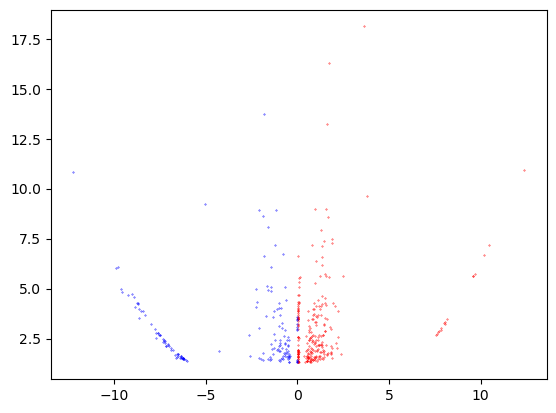

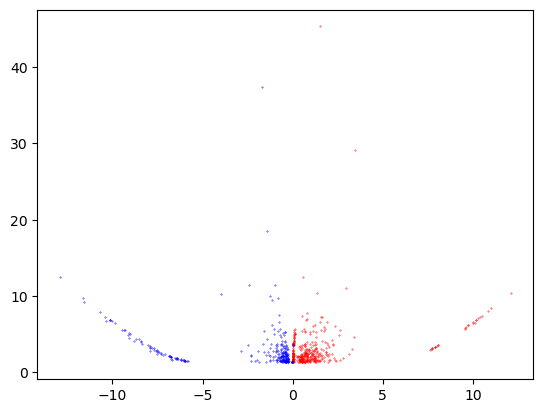

In [20]:
plt.scatter(x=LFC_1_up['log2FoldChange'], y=-np.log10((LFC_1_up['padj'])), s=0.1, c='r')
plt.scatter(x=LFC_1_down['log2FoldChange'], y=-np.log10((LFC_1_down['padj'])), s=0.1, c='b')
plt.show()
plt.close()
plt.scatter(x=LFC_2_up['log2FoldChange'], y=-np.log10((LFC_2_up['padj'])), s=0.1, c='r')
plt.scatter(x=LFC_2_down['log2FoldChange'], y=-np.log10((LFC_2_down['padj'])), s=0.1, c='b')
plt.show()
plt.close()

In [35]:
def results(LFC: pd.DataFrame):
    a_a = len(LFC.query(expr='control == "A" & aux == "A"'))
    a_b = len(LFC.query(expr='control == "A" & aux == "B"'))
    b_a = len(LFC.query(expr='control == "B" & aux == "A"'))
    b_b = len(LFC.query(expr='control == "B" & aux == "B"'))
    return a_a, a_b, b_a, b_b

/tmp/ipykernel_1745591/1561753729.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LFC_1_up['control'] = LFC_1_up['Gene'].apply(lambda x: main(x, control))


values in order: ["A -> A", "A -> B", "B -> A", "B -> B"]
(223, 3, 2, 12)


/tmp/ipykernel_1745591/1561753729.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LFC_1_up['aux'] = LFC_1_up['Gene'].apply(lambda x: main(x, ncaph1))


Text(0.5, 1.0, 'Ncaph1_up')

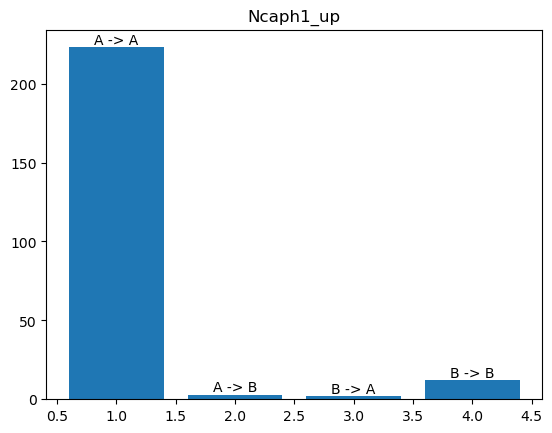

In [38]:
LFC_1_up['control'] = LFC_1_up['Gene'].apply(lambda x: main(x, control))
LFC_1_up['aux'] = LFC_1_up['Gene'].apply(lambda x: main(x, ncaph1))
results_LFC_1_up = results(LFC_1_up)
print('values in order: ["A -> A", "A -> B", "B -> A", "B -> B"]')
print(results_LFC_1_up)
p = plt.bar(x=[1,2,3,4], height = results_LFC_1_up)
plt.bar_label(p, labels=["A -> A", "A -> B", "B -> A", "B -> B"])
plt.title('Ncaph1_up')

/tmp/ipykernel_1745591/3556883206.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LFC_1_down['control'] = LFC_1_down['Gene'].apply(lambda x: main(x, control))


values in order: ["A -> A", "A -> B", "B -> A", "B -> B"]
(139, 2, 1, 2)


/tmp/ipykernel_1745591/3556883206.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LFC_1_down['aux'] = LFC_1_down['Gene'].apply(lambda x: main(x, ncaph1))


Text(0.5, 1.0, 'Ncaph1_down')

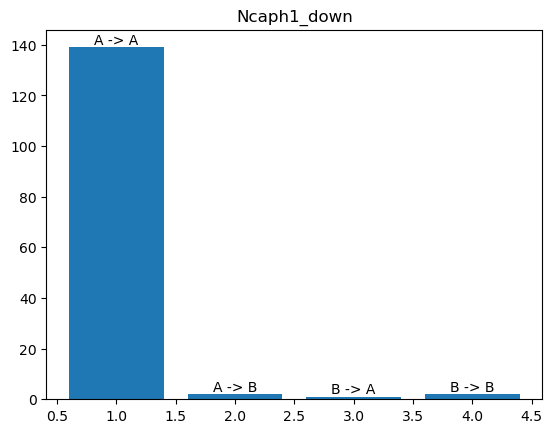

In [39]:
LFC_1_down['control'] = LFC_1_down['Gene'].apply(lambda x: main(x, control))
LFC_1_down['aux'] = LFC_1_down['Gene'].apply(lambda x: main(x, ncaph1))
results_LFC_1_down = results(LFC_1_down)
print('values in order: ["A -> A", "A -> B", "B -> A", "B -> B"]')
print(results_LFC_1_down)
p = plt.bar(x=[1,2,3,4], height = results_LFC_1_down)
plt.bar_label(p, labels=["A -> A", "A -> B", "B -> A", "B -> B"])
plt.title('Ncaph1_down')

/tmp/ipykernel_1745591/1314700751.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LFC_2_up['control'] = LFC_2_up['Gene'].apply(lambda x: main(x, control))


values in order: ["A -> A", "A -> B", "B -> A", "B -> B"]


/tmp/ipykernel_1745591/1314700751.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LFC_2_up['aux'] = LFC_2_up['Gene'].apply(lambda x: main(x, ncaph2))


Text(0.5, 1.0, 'Ncaph2_up')

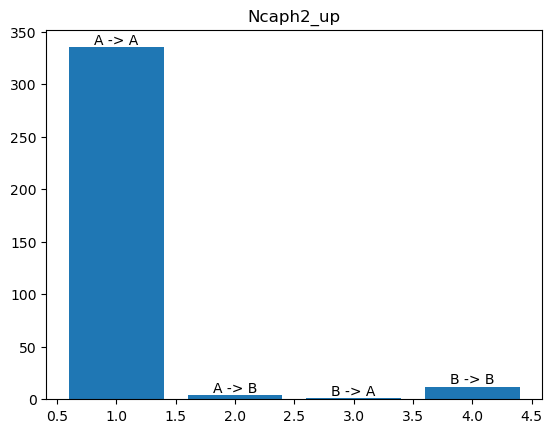

In [40]:
LFC_2_up['control'] = LFC_2_up['Gene'].apply(lambda x: main(x, control))
LFC_2_up['aux'] = LFC_2_up['Gene'].apply(lambda x: main(x, ncaph2))
print('values in order: ["A -> A", "A -> B", "B -> A", "B -> B"]')
results_LFC_2_up = results(LFC_2_up)
p = plt.bar(x=[1,2,3,4], height = results_LFC_2_up)
plt.bar_label(p, labels=["A -> A", "A -> B", "B -> A", "B -> B"])
plt.title('Ncaph2_up')

/tmp/ipykernel_1745591/1260013080.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LFC_2_down['control'] = LFC_2_down['Gene'].apply(lambda x: main(x, control))


values in order: ["A -> A", "A -> B", "B -> A", "B -> B"]
(221, 5, 2, 14)


/tmp/ipykernel_1745591/1260013080.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  LFC_2_down['aux'] = LFC_2_down['Gene'].apply(lambda x: main(x, ncaph2))


Text(0.5, 1.0, 'Ncaph2_down')

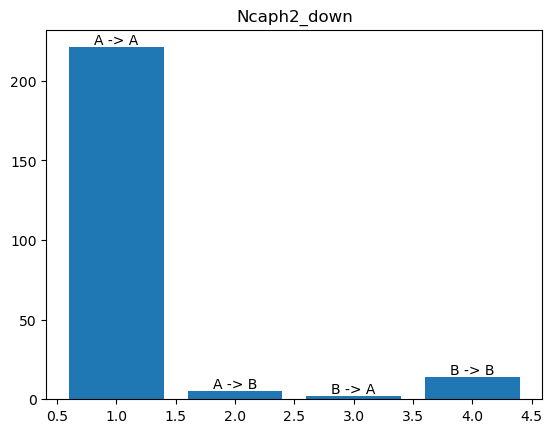

In [41]:
LFC_2_down['control'] = LFC_2_down['Gene'].apply(lambda x: main(x, control))
LFC_2_down['aux'] = LFC_2_down['Gene'].apply(lambda x: main(x, ncaph2))
results = results(LFC_2_down)
print('values in order: ["A -> A", "A -> B", "B -> A", "B -> B"]')
print(results)
p = plt.bar(x=[1,2,3,4], height = results)
plt.bar_label(p, labels=["A -> A", "A -> B", "B -> A", "B -> B"])
plt.title('Ncaph2_down')